In [216]:
from PIL import Image
from os import listdir
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D , Activation, Dropout ,  Flatten, Dense
from keras import backend as K 
from keras.preprocessing import image
import cv2
import itertools
import matplotlib.pyplot as plt
import os


from datetime import datetime
import time
# from module import *

from sklearn.datasets import fetch_openml
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import learning_curve, train_test_split
from skimage.feature import hog
from skimage import data, exposure

from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
import csv


from sklearn import preprocessing, decomposition
from sklearn.decomposition import PCA
from sklearn.svm import SVC




In [180]:
def sift_desc(path):
    #reading the image using imread() function from cv2 module and converting it into gray image
    img = cv2.imread(path,0)
    equ = cv2.equalizeHist(img) 

    #creating a sift object and using detectandcompute() function to detect the keypoints and descriptor from the image
    sift = cv2.xfeatures2d.SIFT_create(500) # nombre de descripteur max recherché par image
    kp, desc = sift.detectAndCompute(equ, None)  # return key points and descriptors
    
    
    #drawing the keypoints and orientation of the keypoints in the image and then displaying the image as the output on the screen
    # kp_img = cv2.drawKeypoints(equ, kp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # cv2.imshow('SIFT', kp_img)
    # cv2.waitKey()
    return desc,sift

In [181]:
def hog(img):
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=True, channel_axis=-1)

In [182]:



# image = data.astronaut()

# fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
#                     cells_per_block=(1, 1), visualize=True, channel_axis=-1)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# ax1.axis('off')
# ax1.imshow(image, cmap=plt.cm.gray)
# ax1.set_title('Input image')

# # Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# ax2.axis('off')
# ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
# ax2.set_title('Histogram of Oriented Gradients')
# plt.show()


In [183]:
# def clean(img):
    
#     img=img.convert(mode='L')
#     img_array=np.asarray(img)

#     return(list(itertools.chain.from_iterable(img_array)))
    


# Extraction

In [184]:
def extract(dic,directory,filename):
    dic['name'].append(filename)
    #add target
    dic['y'].append(re.findall(r"[^\W\d]+",filename)[0])
    # load image
    img_data = Image.open(directory + '/' + filename)
    dic['img_origine'].append(img_data)

    # get description
    desc,sift=sift_desc(directory + '/' + filename)
    dic['desc'].append(desc)
    dic['all_desc'].extend(desc)

    return dic


In [185]:
img_dic = defaultdict(list)
directory = 'photos/dataset'
sift_all_desc = []

for filename in listdir(directory):
    img_dic = extract(img_dic, directory, filename)


In [186]:
len(img_dic['all_desc'])

150144

In [187]:
round(np.sqrt(len(img_dic['all_desc'])))

387

In [188]:
# k = 400 #round(np.sqrt(len(img_dic['sift_all_desc'])))
# k = 10 * len(set(img_dic['y']))  # 10* le nb de target unique c'est le minimum  , ici 40 

k = round(np.sqrt(len(img_dic['all_desc'])))

print(k)
batch_size = np.size(img_dic['name']) * 3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size,
                         verbose=1).fit(img_dic['all_desc'])


387
Init 1/3 with method k-means++
Inertia for init 1/3: 351367585.0
Init 2/3 with method k-means++
Inertia for init 2/3: 351936865.0
Init 3/3 with method k-means++
Inertia for init 3/3: 350127774.0
[MiniBatchKMeans] Reassigning 41 cluster centers.
Minibatch step 1/12512: mean batch inertia: 97411.4475
Minibatch step 2/12512: mean batch inertia: 81489.31250239103, ewa inertia: 81489.31250239103
Minibatch step 3/12512: mean batch inertia: 77614.01371018597, ewa inertia: 81427.36760178633
Minibatch step 4/12512: mean batch inertia: 75825.42307987026, ewa inertia: 81337.82304916986
Minibatch step 5/12512: mean batch inertia: 75088.15100760268, ewa inertia: 81237.92486474973
Minibatch step 6/12512: mean batch inertia: 73258.84050920853, ewa inertia: 81110.38280571814
Minibatch step 7/12512: mean batch inertia: 73691.06636511526, ewa inertia: 80991.78838394288
Minibatch step 8/12512: mean batch inertia: 73084.58376229786, ewa inertia: 80865.39528998738
[MiniBatchKMeans] Reassigning 53 clust

In [189]:
img_dic['desc'][0].shape

(74, 128)

# Histogram

In [190]:
def get_histo(k,desc):
    histo = np.zeros(k)
    nkp = len(desc)

    for d in desc:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly
    return histo


In [191]:
kmeans.verbose = False

histo_list = []

for desc in img_dic['desc']:  # pour chaque liste de descriptor d'image
    histo=get_histo(k,desc)
    histo_list.append(histo)

features = np.asarray(histo_list,dtype=object)
    

In [192]:
df=pd.DataFrame(features)

# Training

In [193]:
species=list(set(img_dic['y']))
species=sorted(species)
species=np.array(species)

In [194]:
species

array(['cloudy', 'rain', 'shine', 'sunrise'], dtype='<U7')

In [196]:
le = preprocessing.LabelEncoder()

X = np.array(histo_list)
Y = np.array(le.fit_transform(img_dic['y']))

mlp = MLPClassifier(verbose=0, max_iter=600000,)
mlp.fit(X, Y)

MLPClassifier(max_iter=600000, verbose=0)

In [197]:
mlp.score(X,Y)

1.0

In [198]:
len(histo_list)

400

In [199]:
len(img_dic['desc'])

400

In [200]:
img_dic['desc'][0].shape

(74, 128)

# Prediction

In [201]:
def pred(k,desc):
    x = np.zeros(k)
    nkp = np.size(desc)

    for d in desc:
        idx = kmeans.predict([d])
        x[idx] += 1/nkp

    res = mlp.predict_proba([x])
    row = []
    row.append(filename)

    for e in res[0]:
        row.append(e)

    result_file_obj.writerow(row)
    return res

In [202]:
result_file = open("sift.csv", "w")
result_file_obj = csv.writer(result_file)
result_file_obj.writerow(np.append("id", species))
results=[]

for desc in img_dic['desc']:
    
    results.append(pred(k,desc))

result_file.close()

# Test

In [203]:
test_dic = defaultdict(list)
test_directory = 'dataset_test'
test_all_desc = []

for filename in listdir(test_directory):
    # print(filename)
    test_dic = extract(test_dic, test_directory, filename)

In [204]:
len(test_dic['y'])

63

In [205]:
test_histo=[]
for desc in test_dic['desc']:
    test_histo.append(get_histo(k,desc))

In [206]:
X_testT = np.array(test_histo)
y_testT = np.array(le.fit_transform(test_dic['y']))

In [208]:
mlp.score(X,Y)

1.0

In [207]:
mlp.score(X_testT,y_testT)

0.5714285714285714

In [226]:
svc = SVC()
svc.fit(X,Y)
svc.score(X_test,y_test)
# svc.score(X,Y)

0.5714285714285714

In [224]:
mlp.score(X_test,y_test) == svc.score(X_test,y_test)

True

# ACP

In [209]:
# selection des colonnes à prendre en compte dans l'ACP
df_centre_reduit = pd.DataFrame(X)
print("{:_} NAN".format(df_centre_reduit.isna().sum().sum()))
df_centre_reduit.shape

0 NAN


(400, 387)

In [210]:
df_centre_reduit

,0,1,2,3,4,5,6,7,8,9,...,377,378,379,380,381,382,383,384,385,386
0,0.000000,0.00000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.013514,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,0.000000,0.013514
1,0.003135,0.00627,0.000,0.003135,0.000000,0.000000,0.003135,0.003135,0.000000,0.000000,...,0.000,0.000000,0.003135,0.003135,0.000000,0.000000,0.012539,0.003135,0.003135,0.000000
2,0.000000,0.00200,0.006,0.000000,0.004000,0.002000,0.002000,0.000000,0.002000,0.008000,...,0.000,0.002000,0.002000,0.000000,0.002000,0.006000,0.004000,0.004000,0.002000,0.000000
3,0.002000,0.00000,0.006,0.000000,0.004000,0.002000,0.004000,0.002000,0.006000,0.002000,...,0.000,0.006000,0.004000,0.002000,0.000000,0.000000,0.000000,0.004000,0.002000,0.002000
4,0.004773,0.00000,0.000,0.000000,0.002387,0.002387,0.007160,0.002387,0.016706,0.004773,...,0.000,0.000000,0.000000,0.002387,0.002387,0.000000,0.004773,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.006000,0.00000,0.006,0.000000,0.008000,0.006000,0.000000,0.016000,0.000000,0.000000,...,0.026,0.000000,0.006000,0.000000,0.000000,0.004000,0.000000,0.000000,0.002000,0.000000
396,0.000000,0.00000,0.000,0.000000,0.002000,0.000000,0.004000,0.002000,0.000000,0.000000,...,0.000,0.000000,0.000000,0.000000,0.000000,0.032000,0.000000,0.000000,0.000000,0.000000
397,0.000000,0.00000,0.000,0.000000,0.000000,0.000000,0.115385,0.000000,0.000000,0.000000,...,0.000,0.007692,0.000000,0.000000,0.000000,0.007692,0.000000,0.007692,0.000000,0.000000
398,0.000000,0.01400,0.002,0.000000,0.004000,0.004000,0.006000,0.002000,0.000000,0.008000,...,0.006,0.000000,0.000000,0.000000,0.008000,0.014000,0.002000,0.000000,0.000000,0.002000


In [211]:
# choix du nombre de composantes à calculer
ACP_NB_COMPOSANTES = df_centre_reduit.shape[1]

# préparation des données pour l'ACP
X_acp = df_centre_reduit.values
names = df_centre_reduit.index # ou data.index pour avoir les intitulés
features = df_centre_reduit.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X_acp)
X_scaled = std_scale.transform(X_acp)

# calculer les composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
x_projeected = pca.fit_transform(X_scaled)
pd.DataFrame(x_projeected, index=df_centre_reduit.index, columns=["F"+str(i+1) for i in range(ACP_NB_COMPOSANTES)])

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F378,F379,F380,F381,F382,F383,F384,F385,F386,F387
0,-11.248493,-1.050401,2.142733,-2.326125,0.841368,2.651836,4.340782,6.054543,0.264985,-3.958938,...,-0.022611,-0.002076,0.012288,0.004441,0.005543,0.000973,-0.002965,0.001834,-0.000227,1.434277e-15
1,-2.438784,-2.613709,-2.352143,-0.285961,-1.429985,1.526960,-1.257289,-0.513592,-0.198161,0.395029,...,-0.004151,-0.013352,0.012049,0.020791,-0.011718,0.006165,-0.006536,-0.003676,-0.000411,1.737236e-15
2,-1.736212,-0.834933,-2.712635,1.628555,1.820176,-1.026585,-0.716569,0.564401,1.103170,-0.797726,...,-0.031445,0.034393,-0.016706,-0.027014,0.010541,0.007419,0.008313,0.003814,0.000780,1.544911e-15
3,-0.594482,3.648975,3.592943,-2.194365,2.133876,0.377459,-2.486398,-0.550187,0.601814,2.245824,...,-0.035440,-0.002721,-0.033925,-0.006798,-0.007083,0.003013,0.000406,-0.001581,-0.000473,1.493148e-15
4,-7.086525,1.074744,-2.238452,-0.225863,0.783822,1.365821,1.512489,-1.898987,0.745760,-1.372739,...,0.014724,-0.006455,0.000484,0.015632,0.004744,0.003314,0.036012,-0.002384,-0.001116,1.583208e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,11.156761,12.163482,2.109467,1.679572,-3.946777,2.846956,0.686899,1.388924,5.677721,-0.927615,...,0.076751,-0.009198,-0.029006,-0.006291,0.013885,0.007365,-0.007703,-0.000481,-0.000038,1.365136e-15
396,10.925212,-9.149475,1.754608,-1.356478,5.574982,-1.821779,3.245798,-0.510282,-0.234522,-1.557646,...,0.005224,-0.050131,-0.003026,0.039016,-0.007404,-0.018182,-0.024194,-0.005119,-0.000216,1.294553e-15
397,2.316652,-5.497362,-2.434057,1.744642,-3.934596,0.811425,-0.844568,-5.710686,-0.327461,-1.064187,...,-0.024949,0.002333,0.031348,0.006491,0.007883,0.016048,0.000181,-0.003123,0.000902,1.465617e-15
398,7.601888,-5.244041,1.521754,0.468194,0.286150,-0.108975,-1.342360,0.691514,-0.670601,1.397081,...,0.022119,-0.017106,0.009865,-0.001166,0.007929,0.001470,0.005595,-0.008901,-0.000378,9.610430e-16


In [212]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.figure(figsize=(18,7), facecolor='white')
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.grid()
    plt.show(block=False)

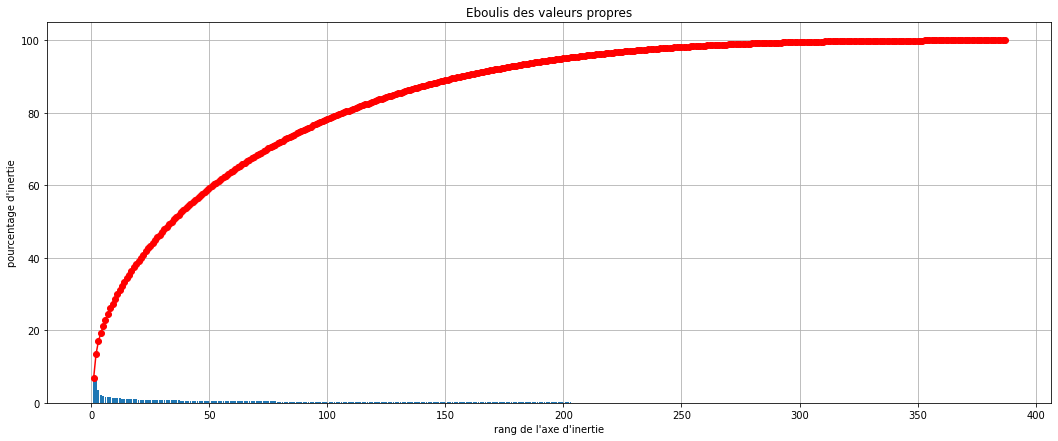

In [213]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

In [214]:
# choix du nombre de composantes à calculer
ACP_NB_COMPOSANTES = 150

axis_ranks = []

for i in range (0, ACP_NB_COMPOSANTES, 2):
    axis_ranks.append((i,i+1))
axis_ranks

[(0, 1),
 (2, 3),
 (4, 5),
 (6, 7),
 (8, 9),
 (10, 11),
 (12, 13),
 (14, 15),
 (16, 17),
 (18, 19),
 (20, 21),
 (22, 23),
 (24, 25),
 (26, 27),
 (28, 29),
 (30, 31),
 (32, 33),
 (34, 35),
 (36, 37),
 (38, 39),
 (40, 41),
 (42, 43),
 (44, 45),
 (46, 47),
 (48, 49),
 (50, 51),
 (52, 53),
 (54, 55),
 (56, 57),
 (58, 59),
 (60, 61),
 (62, 63),
 (64, 65),
 (66, 67),
 (68, 69),
 (70, 71),
 (72, 73),
 (74, 75),
 (76, 77),
 (78, 79),
 (80, 81),
 (82, 83),
 (84, 85),
 (86, 87),
 (88, 89),
 (90, 91),
 (92, 93),
 (94, 95),
 (96, 97),
 (98, 99),
 (100, 101),
 (102, 103),
 (104, 105),
 (106, 107),
 (108, 109),
 (110, 111),
 (112, 113),
 (114, 115),
 (116, 117),
 (118, 119),
 (120, 121),
 (122, 123),
 (124, 125),
 (126, 127),
 (128, 129),
 (130, 131),
 (132, 133),
 (134, 135),
 (136, 137),
 (138, 139),
 (140, 141),
 (142, 143),
 (144, 145),
 (146, 147),
 (148, 149)]

In [215]:
plop()

TypeError: 'int' object is not callable